In [1]:
import pandas as pd

# Load the uploaded Excel file to check its structure
file_path = '../dataset/rab107row.xlsx'
data = pd.read_excel(file_path)

# Display the first few rows to understand the structure
data.head()

,namaproyek,rab,waktu,provinsi,tahun,luas,subitem,tinggi,lantai,ikk,ihbp,inflasi
0,Gedung Apartemen,2.641914e+10,196,Jawa Barat,2019,17401.00,4,21.8,6,103.03,143.72,3.21
1,Gedung Apartemen,8.821079e+10,273,DKI Jakarta,2022,16320.59,6,47.6,14,121.48,107.66,4.21
2,Gedung Apartemen,8.171200e+10,348,DKI Jakarta,2023,23688.00,5,34.0,10,116.73,113.88,2.28
3,Gedung Apartemen,3.690000e+11,830,Banten,2021,55000.00,6,49.8,16,97.64,109.64,1.91
4,Gedung Apartemen,5.400316e+11,700,DKI Jakarta,2023,150000.00,6,105.0,30,116.73,113.88,2.28


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import BayesianRidge, Lasso, LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [3]:
import numpy as np

numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Retry applying log transformation with numpy properly imported
transformed_data = data.copy()
for col in numerical_columns:
    transformed_data[col] = data[col].apply(lambda x: np.log1p(x) if x > 0 else x)

In [4]:
transformed_data.head()

,namaproyek,rab,waktu,provinsi,tahun,luas,subitem,tinggi,lantai,ikk,ihbp,inflasi
0,Gedung Apartemen,23.997354,5.283204,Jawa Barat,7.610853,9.764340,1.609438,3.126761,1.945910,4.644679,4.974801,1.437463
1,Gedung Apartemen,25.202995,5.613128,DKI Jakarta,7.612337,9.700244,1.945910,3.883624,2.708050,4.807948,4.688224,1.650580
2,Gedung Apartemen,25.126467,5.855072,DKI Jakarta,7.612831,10.072766,1.791759,3.555348,2.397895,4.768394,4.743888,1.187843
3,Gedung Apartemen,26.634062,6.722630,Banten,7.611842,10.915107,1.945910,3.927896,2.833213,4.591477,4.706282,1.068153
4,Gedung Apartemen,27.014893,6.552508,DKI Jakarta,7.612831,11.918397,1.945910,4.663439,3.433987,4.768394,4.743888,1.187843


In [5]:
cekduplikat = transformed_data[transformed_data.duplicated()]
cekduplikat

,namaproyek,rab,waktu,provinsi,tahun,luas,subitem,tinggi,lantai,ikk,ihbp,inflasi
22,Gedung Apartemen,26.146404,6.594413,Banten,7.611348,10.465096,1.791759,4.697293,3.465736,4.585478,4.650908,0.896088


In [6]:
transformed_data = transformed_data.drop_duplicates()

cekduplikat = transformed_data[transformed_data.duplicated()]
cekduplikat, transformed_data.shape

(Empty DataFrame
 Columns: [namaproyek, rab, waktu, provinsi, tahun, luas, subitem, tinggi, lantai, ikk, ihbp, inflasi]
 Index: [],
 (106, 12))

In [7]:
# Fungsi untuk mendeteksi outlier menggunakan metode IQR
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Analisis outlier untuk setiap kolom numerik
outlier_results = {}
for col in numerical_columns:
    outliers, lower, upper = detect_outliers_iqr(transformed_data, col)
    outlier_results[col] = {
        "outliers_count": len(outliers),
        "lower_bound": lower,
        "upper_bound": upper
    }

# Menampilkan hasil analisis outlier
outlier_results

{'rab': {'outliers_count': 0,
  'lower_bound': 19.942509309324343,
  'upper_bound': 29.878975866310945},
 'waktu': {'outliers_count': 0,
  'lower_bound': 4.115594293821956,
  'upper_bound': 7.292699322311036},
 'tahun': {'outliers_count': 0,
  'lower_bound': 7.60788543037709,
  'upper_bound': 7.615798390425516},
 'luas': {'outliers_count': 0,
  'lower_bound': 4.626135712885208,
  'upper_bound': 13.50521030326389},
 'subitem': {'outliers_count': 24,
  'lower_bound': 1.5605334494871674,
  'upper_bound': 2.1771361687962005},
 'tinggi': {'outliers_count': 0,
  'lower_bound': 0.5451998640506068,
  'upper_bound': 6.24499765950352},
 'lantai': {'outliers_count': 0,
  'lower_bound': -0.6446193937132167,
  'upper_bound': 4.9199129867178755},
 'ikk': {'outliers_count': 1,
  'lower_bound': 4.459107497071852,
  'upper_bound': 4.953965689101057},
 'ihbp': {'outliers_count': 0,
  'lower_bound': 4.2583580911778816,
  'upper_bound': 5.404666491032535},
 'inflasi': {'outliers_count': 2,
  'lower_bound'

In [8]:
# Fungsi untuk mendeteksi dan menghapus baris yang mengandung outlier
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Hapus baris yang memiliki nilai outlier
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Hapus outlier untuk setiap kolom numerik
data_cleaned = transformed_data.copy()
for col in numerical_columns:
    data_cleaned = remove_outliers_iqr(data_cleaned, col)

In [9]:
data_cleaned.shape

(80, 12)

In [10]:
# Label encoding kolom 'Provinsi' dan nama proyek karena nilainya kategorikal
label_encoder = LabelEncoder()
data_cleaned['label_provinsi'] = label_encoder.fit_transform(data_cleaned['provinsi'])
data_cleaned['label_namaproyek'] = label_encoder.fit_transform(data_cleaned['namaproyek'])

# Melihat nilai unik dari hasil encoding kolom 'provinsi_encoded'
provinsi_unik = data_cleaned[['provinsi', 'label_provinsi']].drop_duplicates().sort_values(
    by='label_provinsi')

# Melihat nilai unik dari hasil encoding kolom 'namaproyek_encoded'
namaproyek_unik = data_cleaned[['namaproyek', 'label_namaproyek']].drop_duplicates().sort_values(
    by='label_namaproyek')

In [11]:
provinsi_unik

,provinsi,label_provinsi
95,Bali,0
3,Banten,1
1,DKI Jakarta,2
0,Jawa Barat,3
23,Jawa Tengah,4
59,Jawa Timur,5
66,Kalimantan Timur,6
55,Kepulauan Riau,7
25,Nusa Tenggara Barat,8
41,Papua,9


In [12]:
namaproyek_unik

,namaproyek,label_namaproyek
0,Gedung Apartemen,0
35,Gedung Asrama,1
43,Gedung Gudang,2
45,Gedung Hotel,3
49,Gedung Kampus,4
55,Gedung Kantor,5
76,Gedung Laboratorium,6
81,Gedung Olahraga,7
83,Gedung Pabrik,8
84,Gedung Parkir,9


In [13]:
# 4. Normalisasi Kolom Numerik
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

numerical_columns = ['waktu', 'tahun', 'luas', 'subitem', 
                     'tinggi', 'lantai', 'ikk', 'ihbp', 'inflasi']
# 4. Normalisasi Kolom Numerik
scalerMinMax = MinMaxScaler()
data_cleaned[numerical_columns] = scalerMinMax.fit_transform(data_cleaned[numerical_columns])

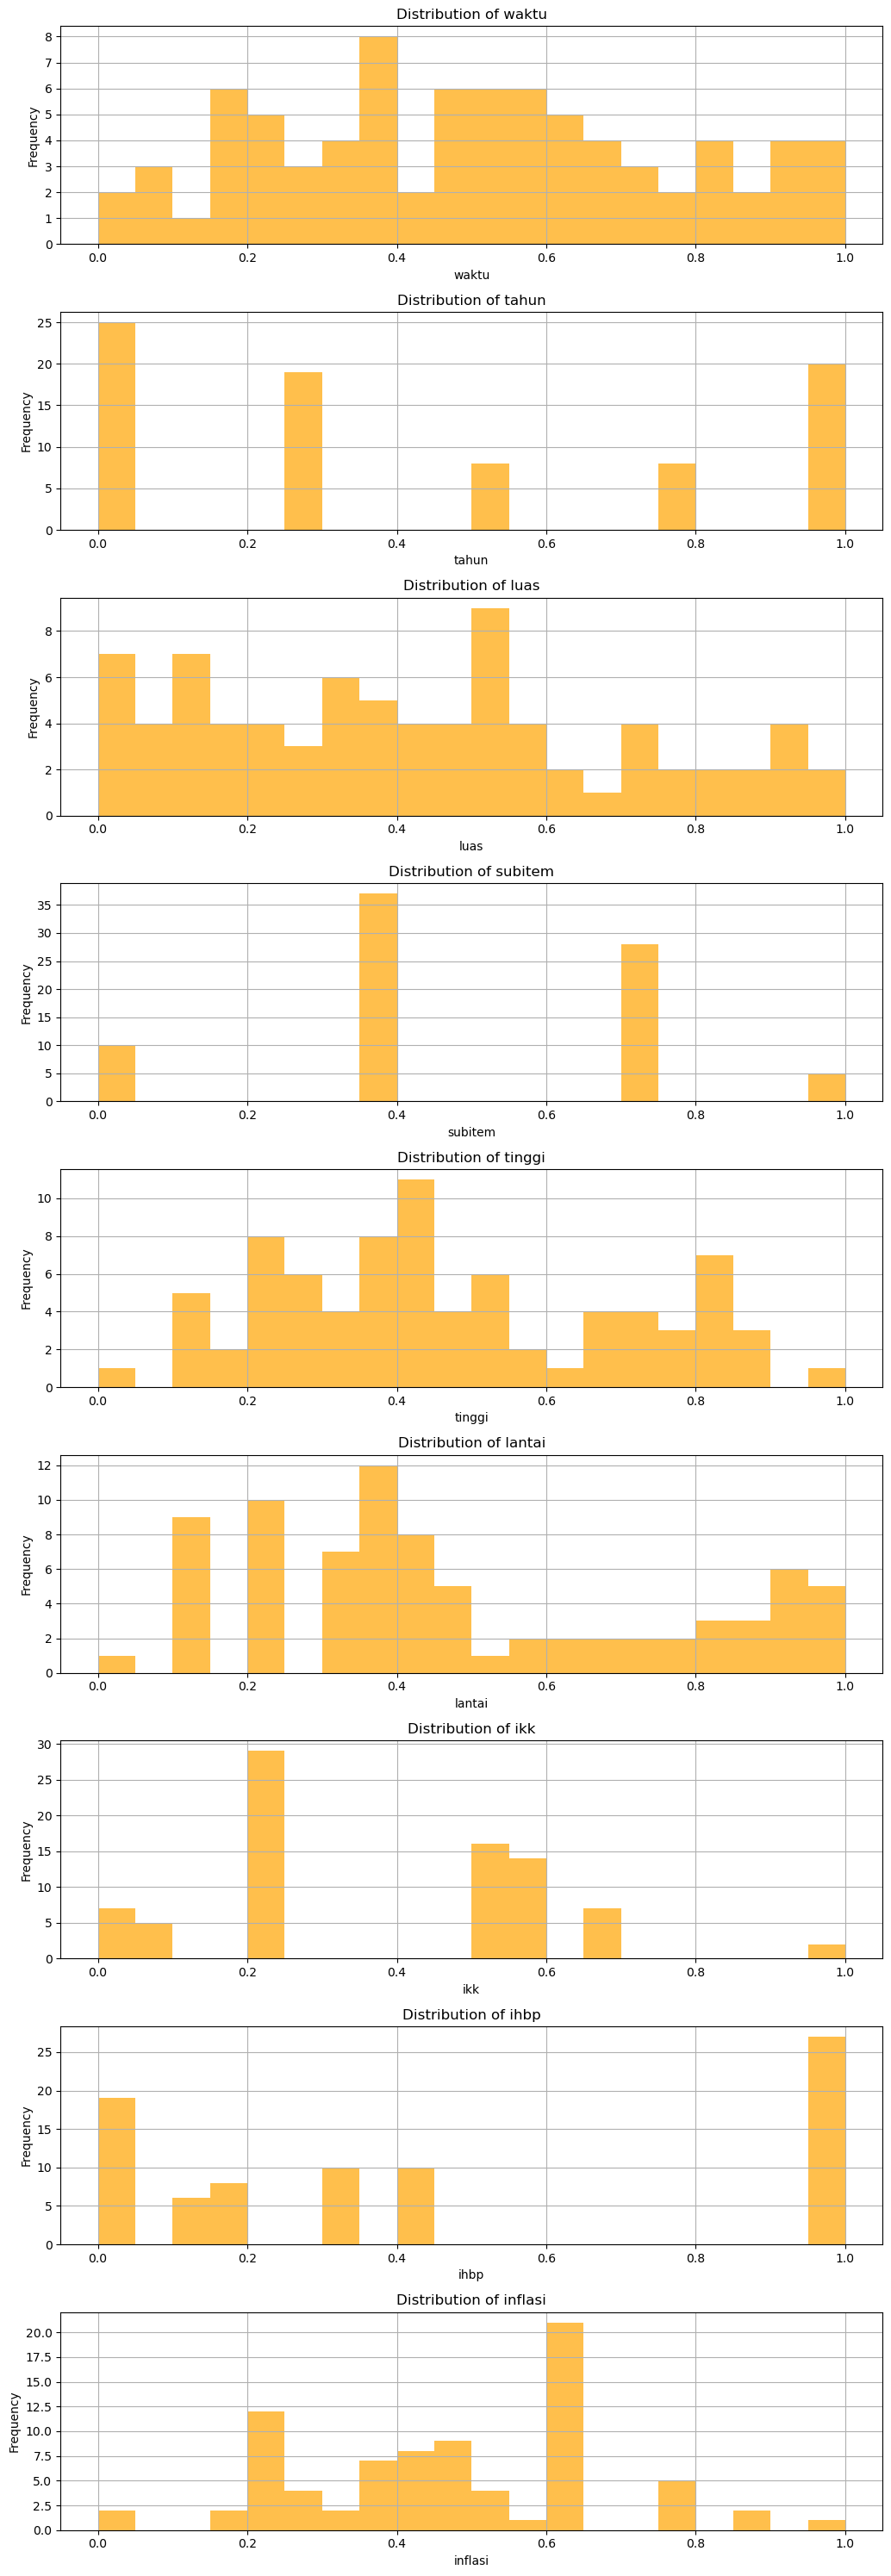

In [14]:
# Compare distributions before and after transformation using histograms
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 30))
for i, col in enumerate(numerical_columns, 1):

    # Transformed data
    plt.subplot(len(numerical_columns), 2, 2 * i)
    data_cleaned[col].hist(bins=20, alpha=0.7, color='orange')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

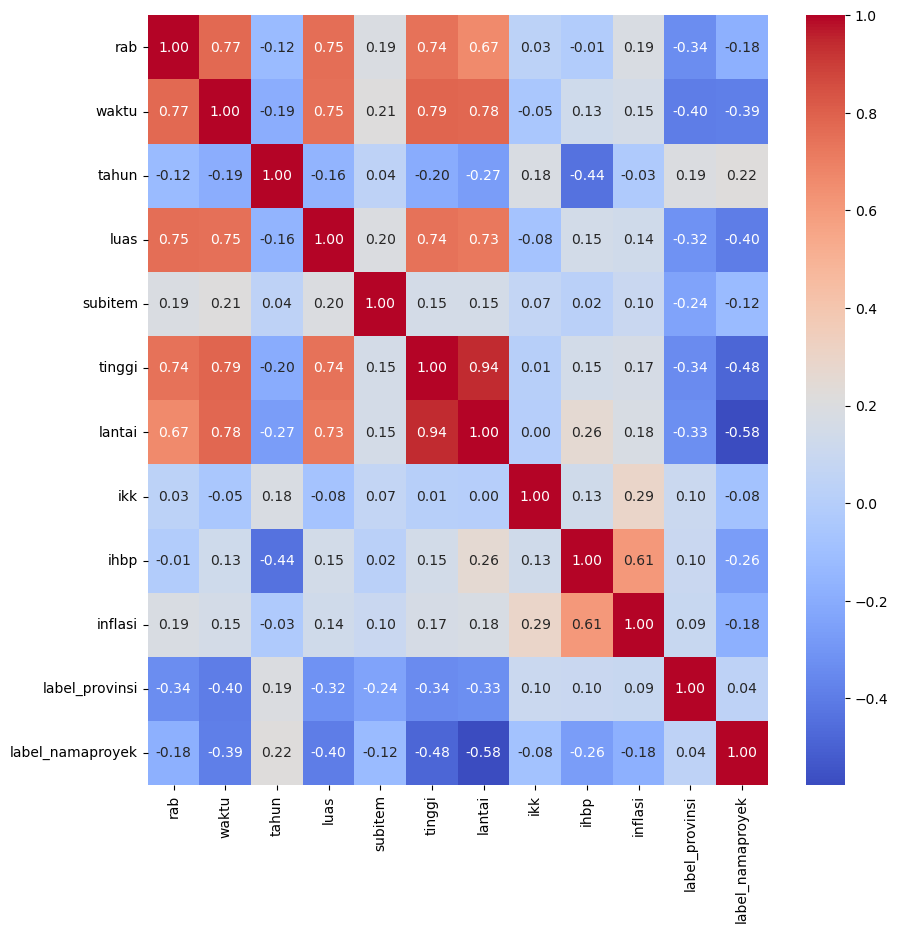

In [15]:
# Digunakan untuk membuat visualisasi dalam bentuk grafik atau plot
import seaborn as sns
import matplotlib.pyplot as plt
# Visualisasi korelasi antar fitur atau kolom apakah saling berpengaruh atau tidak
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(data_cleaned.corr(numeric_only=True), 
            annot=True, cmap='coolwarm', fmt='.2f', ax=ax)
plt.show()

In [16]:
# Split data into features and target
X1 = data_cleaned.drop(columns=[
    'rab', 'namaproyek', 'provinsi', 'lantai'])
y1 = data_cleaned['rab']

# Split into training and testing sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X1, y1, 
    test_size=0.3, 
    random_state=42)

# Split into training and testing sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X1, y1, 
    test_size=0.2, 
    random_state=42)

In [17]:
# Initialize models
models1 = {
    'AdaBoost': AdaBoostRegressor(),
    'Bayesian Ridge': BayesianRidge(),
    'Decision Tree': DecisionTreeRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'KNN Regressor': KNeighborsRegressor(),
    'Lasso Regression': Lasso(),
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'Ridge Regression': Ridge(),
    'SVR': SVR(),
    'XGBoost': xgb.XGBRegressor()
}

models2 = {
    'AdaBoost': AdaBoostRegressor(),
    'Bayesian Ridge': BayesianRidge(),
    'Decision Tree': DecisionTreeRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'KNN Regressor': KNeighborsRegressor(),
    'Lasso Regression': Lasso(),
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'Ridge Regression': Ridge(),
    'SVR': SVR(),
    'XGBoost': xgb.XGBRegressor()
}

# 70:30
# Train and evaluate each model with additional metrics
results1 = []
for name1, model1 in models1.items():
    # Fit model to training data
    model1.fit(X_train1, y_train1)
    
    # Predict on training data
    y_train_pred1 = model1.predict(X_train1)
    
    # Predict on testing data
    y_pred1 = model1.predict(X_test1)
    
    # Calculate metrics for training data
    r2_train1 = r2_score(y_train1, y_train_pred1)
    
    # Calculate metrics for testing data
    mse1 = mean_squared_error(y_test1, y_pred1)
    mae1 = mean_absolute_error(y_test1, y_pred1)
    r21 = r2_score(y_test1, y_pred1)
    
    # Append results
    results1.append({
        'Model': name1,
        'Training R2 Score': r2_train1,
        'Testing RMSE': np.sqrt(mse1),
        'Testing MAE': mae1,
        'Testing R2 Score': r21
    })

# Convert results into a DataFrame for better visualization
results_df1 = pd.DataFrame(results1).sort_values(by='Testing R2 Score', ascending=False)

# 80:20
# Train and evaluate each model with additional metrics
results2 = []
for name2, model2 in models2.items():
    # Fit model to training data
    model2.fit(X_train2, y_train2)
    
    # Predict on training data
    y_train_pred2 = model2.predict(X_train2)
    
    # Predict on testing data
    y_pred2 = model2.predict(X_test2)
    
    # Calculate metrics for training data
    r2_train2 = r2_score(y_train2, y_train_pred2)
    
    # Calculate metrics for testing data
    mse2 = mean_squared_error(y_test2, y_pred2)
    mae2 = mean_absolute_error(y_test2, y_pred2)
    r22 = r2_score(y_test2, y_pred2)
    
    # Append results
    results2.append({
        'Model': name2,
        'Training R2 Score': r2_train2,
        'Testing RMSE': np.sqrt(mse2),
        'Testing MAE': mae2,
        'Testing R2 Score': r22
    })

# Convert results into a DataFrame for better visualization
results_df2 = pd.DataFrame(results2).sort_values(by='Testing R2 Score', ascending=False)


In [18]:
results_df1

,Model,Training R2 Score,Testing RMSE,Testing MAE,Testing R2 Score
7,Random Forest,0.930819,0.645398,0.502062,0.805843
0,AdaBoost,0.924792,0.649032,0.500688,0.803651
8,Ridge Regression,0.759250,0.650896,0.468032,0.802521
3,Gradient Boosting,0.998679,0.660382,0.506983,0.796723
1,Bayesian Ridge,0.782985,0.707531,0.500271,0.766660
10,XGBoost,1.000000,0.726871,0.558088,0.753730
6,Linear Regression,0.787927,0.784194,0.585081,0.713355
2,Decision Tree,1.000000,0.916209,0.715867,0.608720
4,KNN Regressor,0.293848,1.242442,1.036006,0.280468
9,SVR,0.293089,1.295689,1.067453,0.217474


In [19]:
results_df2

,Model,Training R2 Score,Testing RMSE,Testing MAE,Testing R2 Score
10,XGBoost,1.000000,0.521440,0.440594,0.883089
8,Ridge Regression,0.759645,0.629419,0.408560,0.829656
7,Random Forest,0.927993,0.659866,0.476729,0.812777
1,Bayesian Ridge,0.777645,0.684726,0.447111,0.798404
3,Gradient Boosting,0.996536,0.690438,0.481983,0.795027
6,Linear Regression,0.781002,0.740000,0.516679,0.764543
0,AdaBoost,0.910579,0.763091,0.600972,0.749620
2,Decision Tree,1.000000,0.971618,0.748803,0.594082
4,KNN Regressor,0.357278,1.285939,1.063708,0.288969
9,SVR,0.298835,1.324057,1.065418,0.246192


In [20]:
# Ambil model terbaik dari split data 70:30
best_model_name1 = results_df1.iloc[0]['Model']
best_model1 = models1[best_model_name1]

# Ambil model terbaik dari split data 80:20
best_model_name2 = results_df2.iloc[0]['Model']
best_model2 = models2[best_model_name2]


In [21]:
# Prediksi nilai actual dan prediksi untuk 70:30
y_actual1 = y_test1
y_pred_best1 = best_model1.predict(X_test1)

# Prediksi nilai actual dan prediksi untuk 80:20
y_actual2 = y_test2
y_pred_best2 = best_model2.predict(X_test2)


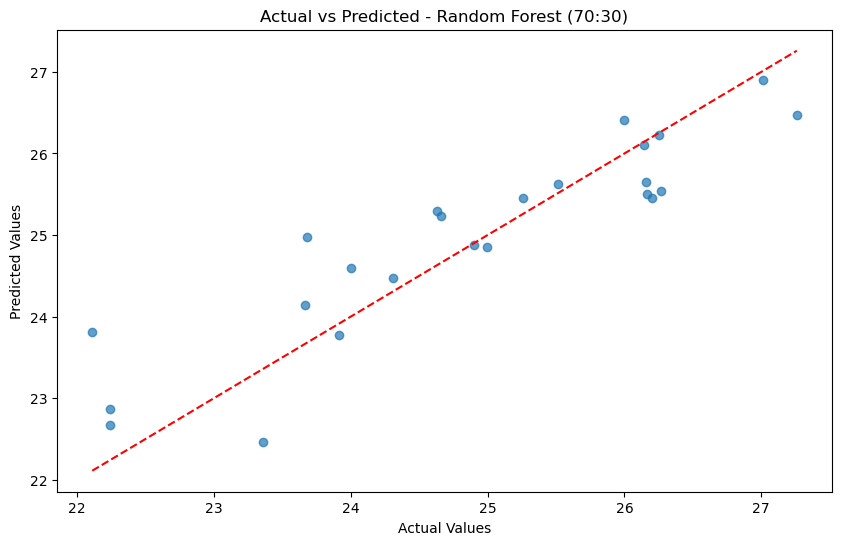

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_actual1, y_pred_best1, alpha=0.7)
plt.plot([y_actual1.min(), y_actual1.max()], [y_actual1.min(), y_actual1.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - {best_model_name1} (70:30)")
plt.show()


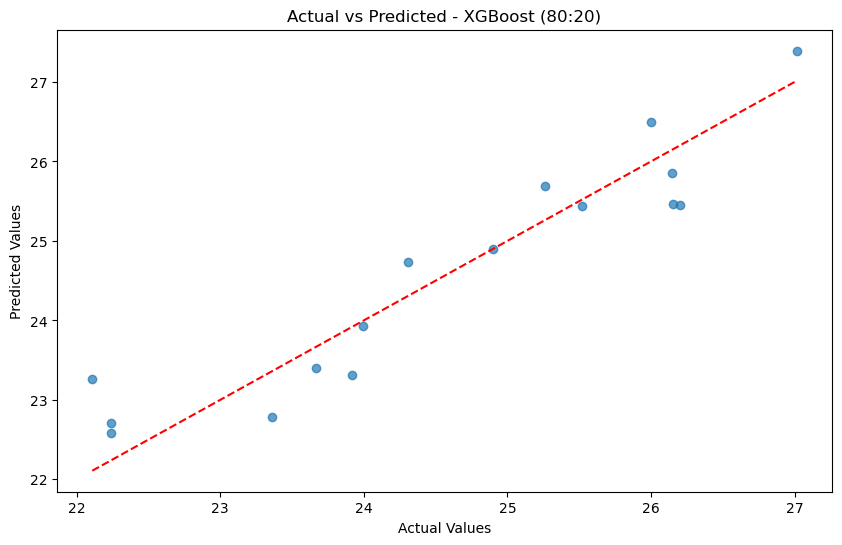

In [23]:
plt.figure(figsize=(10, 6))
plt.scatter(y_actual2, y_pred_best2, alpha=0.7)
plt.plot([y_actual2.min(), y_actual2.max()], [y_actual2.min(), y_actual2.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - {best_model_name2} (80:20)")
plt.show()


In [24]:
# Dataframe untuk 70:30
comparison1 = pd.DataFrame({'Actual': y_actual1, 'Predicted': y_pred_best1})

# Dataframe untuk 80:20
comparison2 = pd.DataFrame({'Actual': y_actual2, 'Predicted': y_pred_best2})

# Tampilkan beberapa baris pertama
print(comparison1.head())
print(comparison2.head())


       Actual  Predicted
38  23.357097  22.461849
0   23.997354  24.590898
27  26.199729  25.459510
39  22.237415  22.670800
21  26.146404  26.099098
       Actual  Predicted
38  23.357097  22.786304
0   23.997354  23.935417
27  26.199729  25.452826
39  22.237415  22.710232
21  26.146404  25.849052


In [25]:
# Kembalikan nilai log ke bentuk asli
comparison1['Actual (Original)'] = np.exp(comparison1['Actual'])
comparison1['Predicted (Original)'] = np.exp(comparison1['Predicted'])

comparison2['Actual (Original)'] = np.exp(comparison2['Actual'])
comparison2['Predicted (Original)'] = np.exp(comparison2['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison1['Actual (Rupiah)'] = comparison1['Actual (Original)'].apply(format_rupiah)
comparison1['Predicted (Rupiah)'] = comparison1['Predicted (Original)'].apply(format_rupiah)

comparison2['Actual (Rupiah)'] = comparison2['Actual (Original)'].apply(format_rupiah)
comparison2['Predicted (Rupiah)'] = comparison2['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison1[['Actual (Rupiah)', 'Predicted (Rupiah)']])
print()
print("*" * 100)
print(comparison2[['Actual (Rupiah)', 'Predicted (Rupiah)']])


       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001    Rp 5.689.276.870
0    Rp 26.419.136.187   Rp 47.829.023.183
27  Rp 239.000.000.001  Rp 114.005.158.624
39    Rp 4.545.551.009    Rp 7.011.376.120
21  Rp 226.589.000.001  Rp 216.119.706.638
35    Rp 4.545.551.009    Rp 8.489.152.302
10  Rp 120.781.089.488  Rp 134.748.115.571
92  Rp 228.530.000.001  Rp 138.273.490.030
4   Rp 540.031.588.145  Rp 479.476.090.249
13  Rp 195.596.000.001  Rp 296.084.786.308
64   Rp 65.000.000.001   Rp 63.456.808.245
41   Rp 24.322.000.001   Rp 21.181.710.194
88   Rp 35.905.245.001   Rp 42.263.122.445
43   Rp 18.970.782.261   Rp 30.581.754.112
89   Rp 93.541.144.803  Rp 113.157.382.219
59    Rp 3.997.225.850   Rp 21.907.580.136
95  Rp 690.000.000.001  Rp 312.046.811.083
78   Rp 49.559.404.693   Rp 96.266.315.653
72  Rp 230.570.298.290  Rp 119.075.558.984
52  Rp 254.967.000.193  Rp 122.853.534.470
9   Rp 251.146.002.001  Rp 244.636.914.608
83   Rp 71.420.000.001   Rp 62.372.452.148
5    Rp 51.

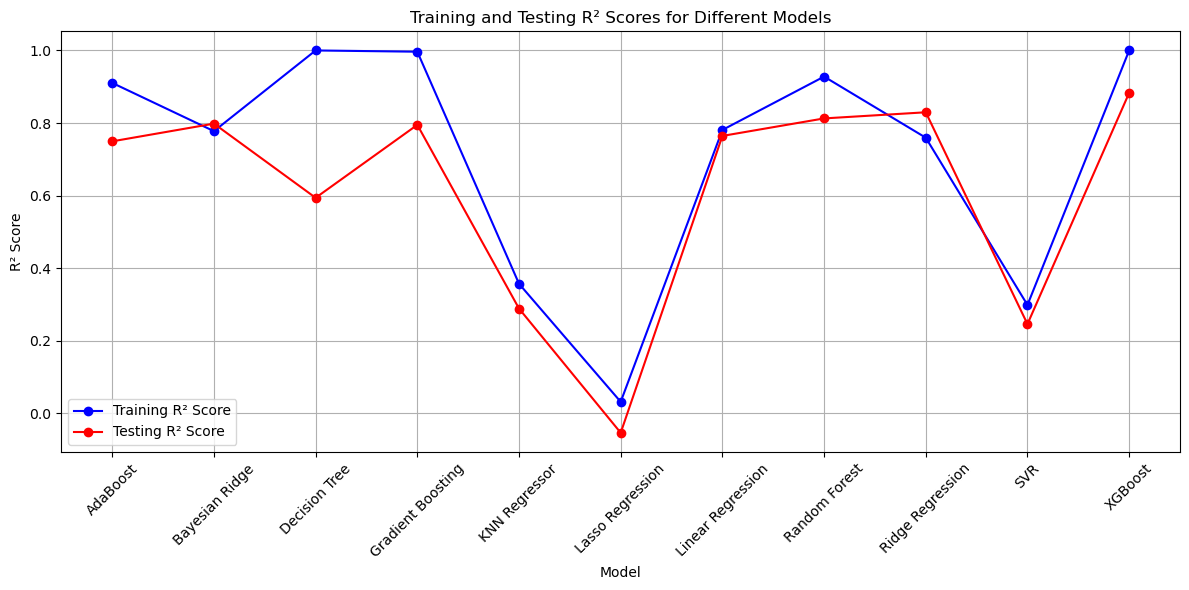

In [26]:
import matplotlib.pyplot as plt

# Extract model names and their corresponding R² scores
model_names = [r['Model'] for r in results2]
train_r2_scores = [r['Training R2 Score'] for r in results2]
test_r2_scores = [r['Testing R2 Score'] for r in results2]


# Set the figure size
plt.figure(figsize=(12, 6))

# Plot Training R² Scores
plt.plot(model_names, train_r2_scores, 'bo-', label='Training R² Score')

# Plot Testing R² Scores
plt.plot(model_names, test_r2_scores, 'ro-', label='Testing R² Score')

# Customize the plot
plt.xlabel('Model')
plt.ylabel('R² Score')
plt.title('Training and Testing R² Scores for Different Models')
plt.xticks(rotation=45)  # Rotate model names for better visibility
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


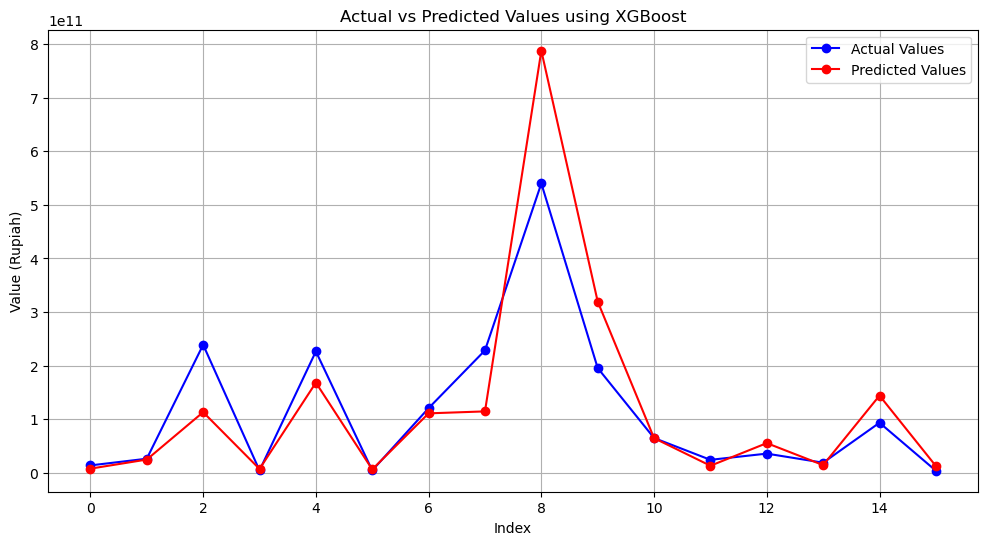

In [32]:
# Identify the best model based on Testing R² Score
best_model_name = results_df2.iloc[0]['Model']
best_model = models2[best_model_name]

# Predict on the test data
y_pred_log = best_model.predict(X_test2)

# If your target variable was log-transformed, revert it back
y_actual = np.exp(y_test2.reset_index(drop=True))
y_pred = np.exp(y_pred_log)

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Actual': y_actual,
    'Predicted': y_pred
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df.index, comparison_df['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df.index, comparison_df['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using {best_model_name}')
plt.legend()
plt.grid(True)
plt.show()


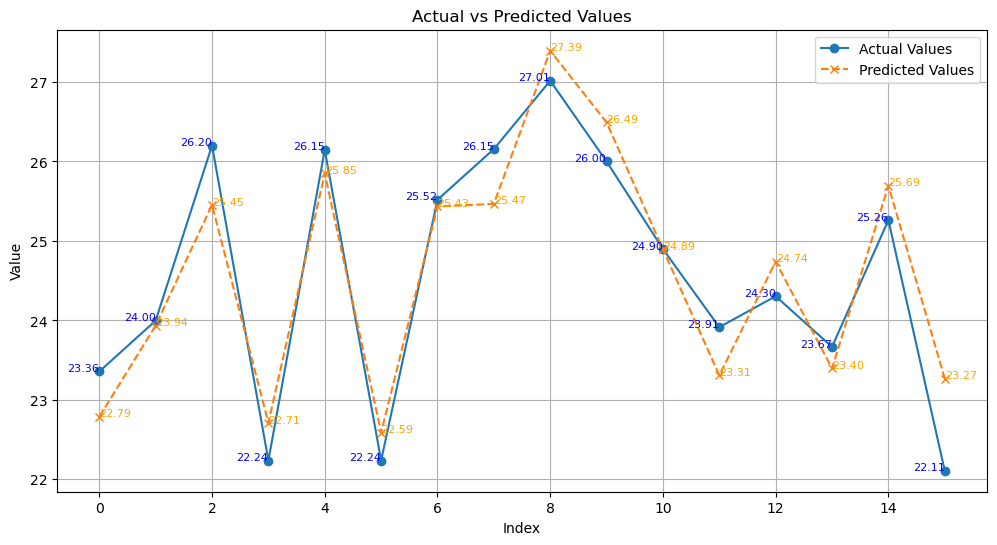

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Pastikan data berbentuk array (jika tidak, ubah dengan np.array)
y_test = np.array(y_test2)  # Nilai aktual
y_pred = np.array(y_pred_log)  # Nilai prediksi

# Buat plot
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='Actual Values', marker='o', linestyle='-')
plt.plot(range(len(y_pred)), y_pred, label='Predicted Values', marker='x', linestyle='--')

# Tambahkan angka di setiap titik
for i, (y_actual, y_predict) in enumerate(zip(y_test, y_pred)):
    plt.text(i, y_actual, f'{y_actual:.2f}', fontsize=8, ha='right', color='blue')
    plt.text(i, y_predict, f'{y_predict:.2f}', fontsize=8, ha='left', color='orange')

# Tambahkan label dan judul
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)

# Tampilkan plot
plt.show()

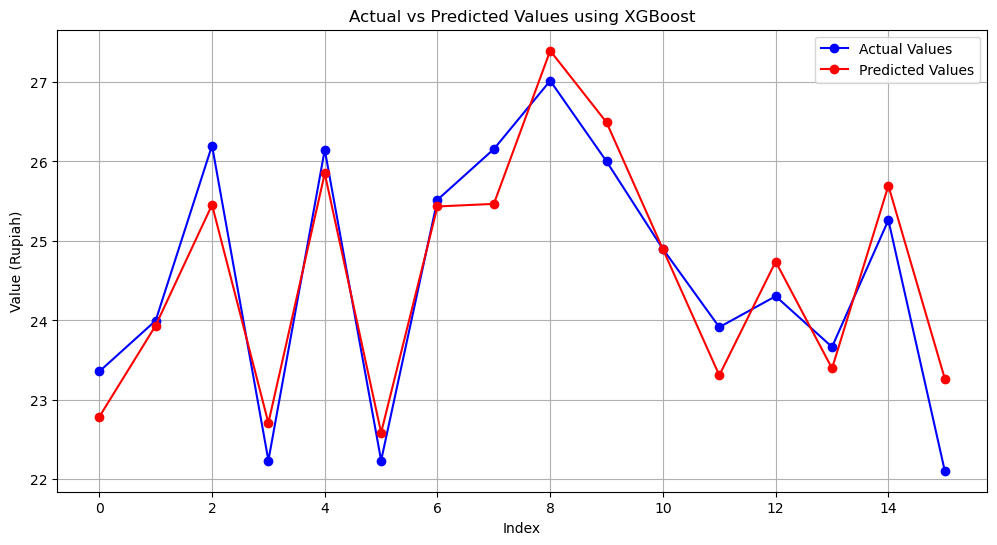

In [33]:
# Identify the best model based on Testing R² Score
best_model_name = results_df2.iloc[0]['Model']
best_model = models2[best_model_name]

# Predict on the test data
y_pred = best_model.predict(X_test2)

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Actual': y_test2.reset_index(drop=True),
    'Predicted': y_pred
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df.index, comparison_df['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df.index, comparison_df['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using {best_model_name}')
plt.legend()
plt.grid(True)
plt.show()


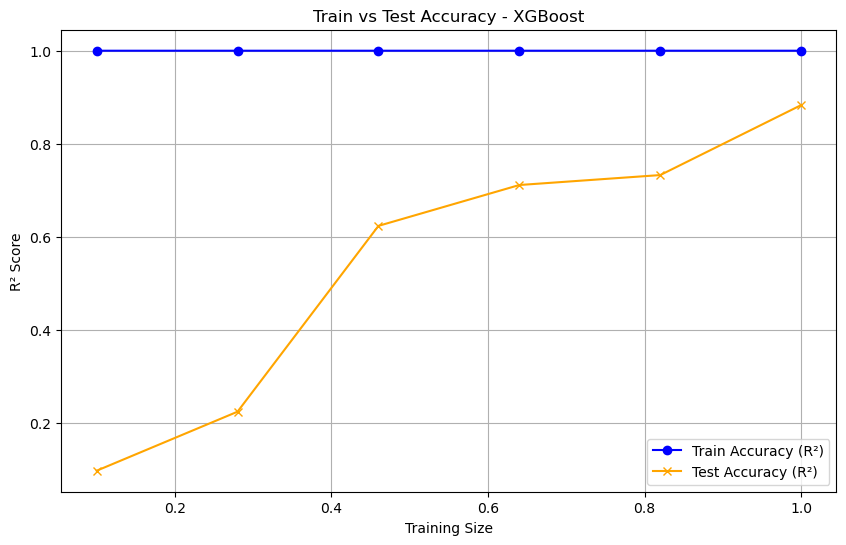

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Model terbaik dari results_df1
best_model_name = results_df2.iloc[0]['Model']
best_model = models2[best_model_name]

# Training sizes (misalnya dalam persen data training)
training_sizes = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best = []
test_accuracies_best = []

for size in training_sizes:
    # Tentukan jumlah data training sesuai ukuran
    train_size = int(size * len(X_train2))
    X_train_subset = X_train2[:train_size]
    y_train_subset = y_train2[:train_size]
    
    # Fit model dengan subset data
    best_model.fit(X_train_subset, y_train_subset)
    
    # Prediksi untuk data training dan testing
    y_train_pred = best_model.predict(X_train_subset)
    y_test_pred = best_model.predict(X_test2)
    
    # Hitung R² Score
    train_accuracies_best.append(r2_score(y_train_subset, y_train_pred))
    test_accuracies_best.append(r2_score(y_test2, y_test_pred))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes, train_accuracies_best, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes, test_accuracies_best, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - {best_model_name}')
plt.grid(True)
plt.legend()
plt.show()


In [37]:
from sklearn.model_selection import cross_val_score

# Model terbaik
best_model_name = results_df2.iloc[0]['Model']
best_model = models2[best_model_name]

# Cross-validation
cv_folds = 5  # Jumlah lipatan (folds)
cv_scores = cross_val_score(best_model, X_train2, y_train2, cv=cv_folds, scoring='r2')

# Rata-rata dan standar deviasi R² Score dari cross-validation
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)

# Tampilkan hasil
print(f"Cross-Validation Scores (R²): {cv_scores}")
print(f"Mean R² Score: {mean_cv_score:.4f}")
print(f"Standard Deviation: {std_cv_score:.4f}")


Cross-Validation Scores (R²): [0.20165794 0.71218577 0.15494194 0.23657382 0.46369003]
Mean R² Score: 0.3538
Standard Deviation: 0.2083


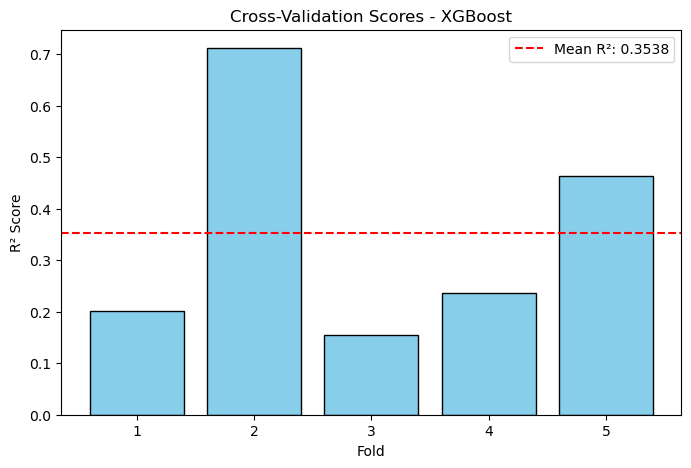

In [38]:
plt.figure(figsize=(8, 5))
plt.bar(range(1, cv_folds + 1), cv_scores, color='skyblue', edgecolor='black')
plt.axhline(y=mean_cv_score, color='red', linestyle='--', label=f"Mean R²: {mean_cv_score:.4f}")
plt.xlabel('Fold')
plt.ylabel('R² Score')
plt.title(f'Cross-Validation Scores - {best_model_name}')
plt.legend()
plt.show()


In [39]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Definisikan parameter yang akan dituning untuk model XGBoost
param_grid = {
    'n_estimators': [50, 100, 200, 300],       # Jumlah estimators
    'learning_rate': [0.01, 0.1, 0.2, 0.3],   # Learning rate
    'max_depth': [3, 5, 7, 9],                # Maksimum kedalaman pohon
    'subsample': [0.6, 0.8, 1.0],             # Proporsi sampel untuk membangun setiap pohon
    'colsample_bytree': [0.6, 0.8, 1.0],      # Proporsi fitur yang digunakan untuk setiap pohon
    'gamma': [0, 1, 5],                       # Minimum reduction loss untuk split
    'reg_alpha': [0, 0.1, 1],                 # Regularisasi L1
    'reg_lambda': [1, 2, 5]                   # Regularisasi L2
}

# Inisialisasi model XGBoost
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='r2', verbose=1, n_jobs=-1)

# Jalankan GridSearchCV
grid_search.fit(X_train2, y_train2)

# Hasil terbaik
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation R² Score: {best_score:.4f}")


Fitting 5 folds for each of 15552 candidates, totalling 77760 fits
Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 2, 'subsample': 0.6}
Best Cross-Validation R² Score: 0.6119


In [40]:
# Model dengan parameter terbaik
best_model_tuned = xgb.XGBRegressor(**best_params)
best_model_tuned.fit(X_train2, y_train2)

# Prediksi pada data testing
y_pred_tuned = best_model_tuned.predict(X_test2)

# Evaluasi performa
r2_tuned = r2_score(y_test2, y_pred_tuned)
print(f"Testing R² Score (Tuned Model): {r2_tuned:.4f}")


Testing R² Score (Tuned Model): 0.7977


Testing R² Score (Tuned Model): 0.7977


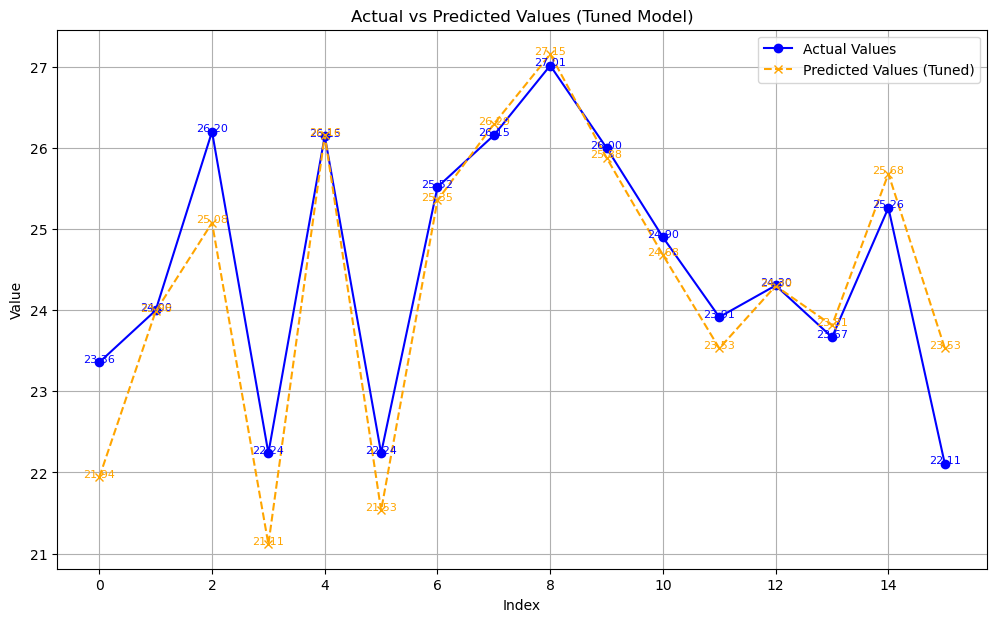

In [41]:
import matplotlib.pyplot as plt

# Model dengan parameter terbaik setelah tuning
best_model_tuned = xgb.XGBRegressor(**grid_search.best_params_)
best_model_tuned.fit(X_train2, y_train2)

# Prediksi pada data testing
y_pred_tuned = best_model_tuned.predict(X_test2)

# Evaluasi performa
r2_tuned = r2_score(y_test2, y_pred_tuned)
print(f"Testing R² Score (Tuned Model): {r2_tuned:.4f}")

# Visualisasi Hasil: Actual vs Predicted
plt.figure(figsize=(12, 7))
plt.plot(range(len(y_test2)), y_test2, 'o-', label='Actual Values', color='blue')
plt.plot(range(len(y_pred_tuned)), y_pred_tuned, 'x--', label='Predicted Values (Tuned)', color='orange')
for i, (a, p) in enumerate(zip(y_test2, y_pred_tuned)):
    plt.text(i, a, f"{a:.2f}", color="blue", fontsize=8, ha='center')
    plt.text(i, p, f"{p:.2f}", color="orange", fontsize=8, ha='center')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values (Tuned Model)')
plt.legend()
plt.grid(True)
plt.show()

In [42]:
print("Best Parameters after Tuning:", grid_search.best_params_)


Best Parameters after Tuning: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 2, 'subsample': 0.6}


Testing R² Score (Tuned Model): 0.7977


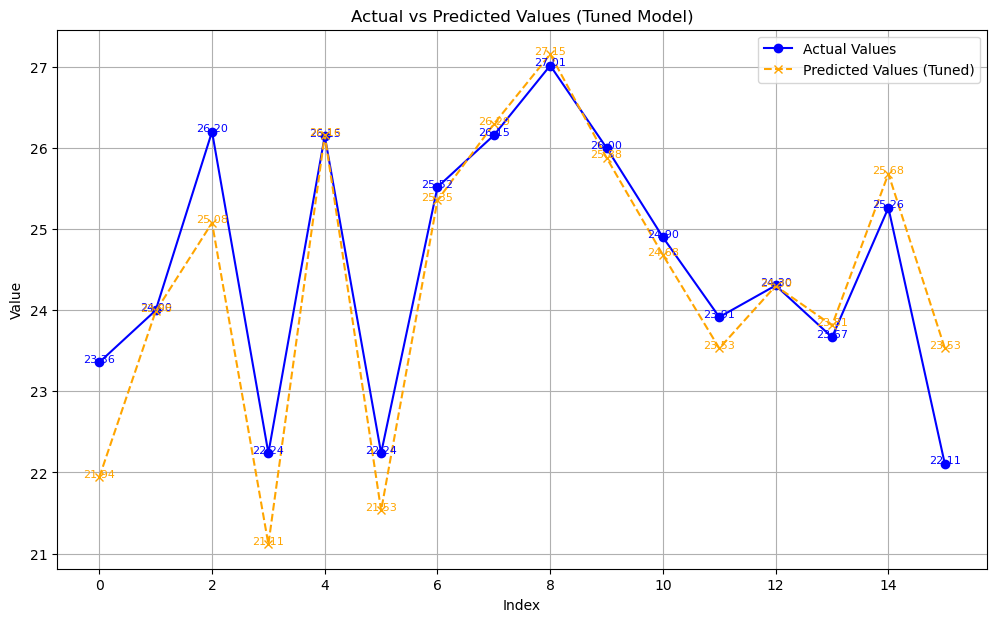

In [46]:
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree= 1.0, 
    gamma= 0, 
    learning_rate= 0.1, 
    max_depth= 3, 
    n_estimators= 100, 
    reg_alpha= 0, 
    reg_lambda= 2, 
    subsample= 0.6
)

xgb_model.fit(X_train2, y_train2)

# Prediksi pada data testing
y_pred_tuned = xgb_model.predict(X_test2)

# Evaluasi performa
r2_tuned = r2_score(y_test2, y_pred_tuned)
print(f"Testing R² Score (Tuned Model): {r2_tuned:.4f}")

# Visualisasi Hasil: Actual vs Predicted
plt.figure(figsize=(12, 7))
plt.plot(range(len(y_test2)), y_test2, 'o-', label='Actual Values', color='blue')
plt.plot(range(len(y_pred_tuned)), y_pred_tuned, 'x--', label='Predicted Values (Tuned)', color='orange')
for i, (a, p) in enumerate(zip(y_test2, y_pred_tuned)):
    plt.text(i, a, f"{a:.2f}", color="blue", fontsize=8, ha='center')
    plt.text(i, p, f"{p:.2f}", color="orange", fontsize=8, ha='center')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values (Tuned Model)')
plt.legend()
plt.grid(True)
plt.show()